<a href="https://colab.research.google.com/github/Alejandro-XIII/Proyecto-Final-SO/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scheduling

##FCFS

In [5]:
def fcfs(processes):
    processes_sorted = sorted(processes, key=lambda x: x['arrival_time'])
    scheduling = []
    time = 0
    for process in processes_sorted:
      time += process['run_time']
      scheduling.append((process['name'], time))
    return scheduling

##SJF

In [6]:
def sjf(processes):
    processes_remaining = [{'name': p['name'], 'arrival_time': p['arrival_time'], 'run_time': p['run_time']} for p in processes] # Crear una copia de los procesos para no modificar la entrada original
    scheduling = []
    time = 0
    while processes_remaining:
      available_processes = [p for p in processes_remaining if p['arrival_time'] <= time] # Actualizar la lista de procesos restantes filtrando por arrival_time <= time
      shortest_process = min(available_processes, key=lambda x: x['run_time']) # Encontrar el proceso con la menor duración de tiempo restante
      time += shortest_process['run_time']
      processes_remaining.remove(shortest_process)
      scheduling.append((shortest_process['name'], time))
    return scheduling


##STCF

In [7]:
def stcf(processes):
    processes_remaining = [{'name': p['name'], 'arrival_time': p['arrival_time'], 'run_time': p['run_time']} for p in processes] # Crear una copia de los procesos para no modificar la entrada original
    max_arrival_time = max(processes_remaining, key=lambda p: p['arrival_time'])['arrival_time'] # Obtener el arrival_time más alto
    scheduling = []
    time = 0
    while processes_remaining:
      if time < max_arrival_time:
        available_processes = [p for p in processes_remaining if p['arrival_time'] <= time] # Actualizar la lista de procesos restantes filtrando por arrival_time <= time
        shortest_process = min(available_processes, key=lambda x: x['run_time']) # Encontrar el proceso con la menor duración de tiempo restante
        next_arrival_time  = min([p['arrival_time'] for p in processes_remaining if p['arrival_time'] > time]) # Actualizar el siguiente arrival_time
        if shortest_process['run_time'] < (next_arrival_time-time):
          time += shortest_process['run_time']
          processes_remaining.remove(shortest_process)
        else:
          next(p for p in processes_remaining if p['name'] == shortest_process['name'])['run_time'] -= (next_arrival_time-time)
          time = next_arrival_time
        if scheduling and scheduling[-1][0] == shortest_process['name']:
          scheduling[-1] = (shortest_process['name'], time)
        else:
          scheduling.append((shortest_process['name'], time))
      else:
        processes_sorted = sorted(processes_remaining, key=lambda x: x['run_time'])
        for process in processes_sorted:
          time += process['run_time']
          if scheduling and scheduling[-1][0] == process['name']:  # Si el último proceso en scheduling es el mismo que el process, actualizamos el último tiempo
            scheduling[-1] = (process['name'], time)
          else:
            scheduling.append((process['name'], time))
          processes_remaining.remove(process)
    return scheduling


##RR

In [8]:
def rr(processes, quantum):
    processes_remaining = [{'name': p['name'], 'arrival_time': p['arrival_time'], 'run_time': p['run_time']} for p in processes]
    scheduling = []
    time = 0
    queue = []  # Cola de procesos listos para ejecutarse
    while processes_remaining or queue:
        for process in processes_remaining:
            if process['arrival_time'] <= time and process not in queue:
                queue.insert(0, process)  # Insertamos el nuevo proceso al principio de la cola
        process = queue.pop(0)  # Tomamos el primer proceso de la cola
        if process['run_time'] > quantum:  # Si el proceso no termina en este quantum, se le resta el tiempo del quantum y se vuelve a poner en la cola
            process['run_time'] -= quantum
            time += quantum
            queue.append(process)  # Volvemos a agregar el proceso al final de la cola si aún tiene tiempo restante
        else:  # Si el proceso termina en este quantum, lo ejecutamos completamente
            time += process['run_time']
            process['run_time'] = 0  # El proceso ya terminó
        scheduling.append((process['name'], time))
        processes_remaining = [p for p in processes_remaining if p['name'] != process['name']] # Eliminamos el proceso de la lista de procesos restantes
    return scheduling


##Imprimir scheduling

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define un diccionario de colores para cada proceso
process_colors = {
    'A': 'red',     # Color para el proceso A
    'B': 'blue',    # Color para el proceso B
    'C': 'green',   # Color para el proceso C
    # Agrega más procesos y colores según sea necesario
}

def plot_scheduling(scheduling, tt, tr):
    start_time = 0
    positions = []
    for name, end_time in scheduling:
        positions.append((name, start_time, end_time - start_time))
        start_time = end_time

    fig, ax = plt.subplots(figsize=(10, 2))  # Ajusta el tamaño de la figura
    ax.set_xlim(0, scheduling[-1][1])  # Fija el límite del eje x
    ax.set_ylim(0, 1)  # Fija el límite del eje y

    for name, start, duration in positions:
        color = process_colors.get(name, 'gray')  # Obtiene el color o usa gris por defecto
        rect = patches.Rectangle((start, 0.5), duration, 0.3, edgecolor='black', facecolor=color)
        ax.add_patch(rect)
        ax.text(start + duration / 2, 0.65, name, ha='center', va='center', color='white', fontsize=10)

    ax.get_yaxis().set_visible(False)  # Oculta el eje y
    ax.set_xlabel(f"TT: {tt}         TR: {tr}")

    plt.show()

##Tturnaround

In [10]:
def t_turnaround(scheduling, processes):
  t_turnaround = 0
  for process in processes:
    for name, t_completion in reversed(scheduling):
      if name == process['name']:
        t_turnaround += t_completion - process['arrival_time']
        break
  return t_turnaround / len(processes)

##Tresponse

In [11]:
def t_response(scheduling, processes):
  t_response = 0
  for process in processes:
    for i in range(len(scheduling)):
      if scheduling[i][0] == process['name']:
        if i == 0: t_firstrun = 0
        else: t_firstrun = scheduling[i-1][1]
        t_response += t_firstrun - process['arrival_time']
        break
  return t_response / len(processes)

#Modelo

##Dependencias

In [1]:
# Primero, reinstalar numpy y pandas en versiones estables en Colab.
!pip install numpy==1.23.5 pandas==2.2.2

# Instalar gymnasium y shimmy, que son más compatibles con versiones recientes de stable-baselines3
!pip install gymnasium==0.28.1 shimmy==0.2.1

# Instalar la versión más reciente de stable-baselines3
!pip install stable-baselines3

# Instalar PyTorch, ya que stable-baselines3 necesita esta dependencia
!pip install torch==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 0.28.1
    Uninstalling gymnasium-0.28.1:
      Successfully uninstalled gymnasium-0.28.1
  Using cached torch-2.5.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cach

##Entorno de planificación de procesos

In [20]:
import gym
from gym import spaces
import numpy as np

class ProcessSchedulingEnv(gym.Env):
  def __init__(self, processes):
    super(ProcessSchedulingEnv, self).__init__()
    self.processes = processes
    self.current_time = 0
    self.execution_history = []  # Historial de todas las ejecuciones
    self.best_execution = []  # La mejor ejecución
    self.remaining_times = [p['run_time'] for p in processes]
    self.last_process = None  # Para rastrear el último proceso ejecutado
    self.action_space = spaces.Discrete(len(processes))  # Espacio de acciones: un índice de proceso
    self.observation_space = spaces.Box( # Definimos la observación como los tiempos restantes de cada proceso
      low=0, high=np.inf, shape=(len(processes),), dtype=np.float32
    )

  def reset(self): # Reiniciar el estado del entorno
    self.current_time = 0
    self.execution_history = []  # Reiniciar el historial de ejecuciones
    self.remaining_times = [p['run_time'] for p in self.processes]
    self.last_process = None  # Reiniciar el último proceso
    return np.array(self.remaining_times, dtype=np.float32)

  def step(self, action):
    valid_actions = [  # Filtrar las acciones válidas
      i for i, (rt, p) in enumerate(zip(self.remaining_times, self.processes))
        if rt > 0 and self.current_time >= p['arrival_time']
    ]
    if valid_actions and action not in valid_actions:  # Si la acción no es válida retorna con penalización
      return np.array(self.remaining_times), -100, False, {}  # Penalización
    self.remaining_times[action] -= 1 # Ejecutar 1 unidad de tiempo
    self.current_time += 1
    if self.last_process != self.processes[action]['name']: # Registrar la ejecución si es un cambio de proceso
      self.execution_history.append((self.processes[action]['name'], self.current_time))
      self.last_process = self.processes[action]['name']
    else:
      self.execution_history[-1] = (self.execution_history[-1][0], self.current_time) # Modificar la última tupla en self.execution_history
    done = all(rt <= 0 for rt in self.remaining_times) # Verificar si todos los procesos han terminado
    tt = t_turnaround(self.execution_history, self.processes)
    tr = t_response(self.execution_history, self.processes)
    if done:
      if not self.best_execution: self.best_execution = self.execution_history.copy() # Si mejor ejecución está vacía, se agrega
      else: # Sino se compara compara para encontrar la mejor
        tt_b = t_turnaround(self.best_execution, self.processes)
        tr_b = t_response(self.best_execution, self.processes)
        if (tt+tr) < (tt_b+tr_b): self.best_execution = self.execution_history.copy()
    reward = 100-(tr+tt) # Calcular recompensa
    return np.array(self.remaining_times, dtype=np.float32), reward, done, {}

##Entrenamiento de modelo PPO

In [23]:
from stable_baselines3 import PPO

def modelo(processes):
    env = ProcessSchedulingEnv(processes) # Instanciar el entorno y el modelo PPO
    model = PPO("MlpPolicy", env, verbose=0)
    model.learn(total_timesteps=100) # Entrenar el modelo
    obs = env.reset() # Evaluación del modelo
    done = False
    while not done:
      action, _states = model.predict(obs, deterministic=False) # Predecir acción
      obs, reward, done, info = env.step(action)
    return env.best_execution # Resultados finales de la predicción

# Pruebas

##Definir procesos

In [13]:
processes = [
    {'name': 'A', 'arrival_time': 0, 'run_time': 5},
    {'name': 'B', 'arrival_time': 2, 'run_time': 3},
    {'name': 'C', 'arrival_time': 4, 'run_time': 7},
]

##FCFS

[('A', 5), ('B', 8), ('C', 15)]


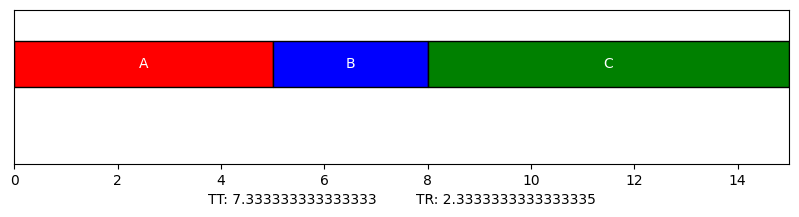

In [14]:
scheduling = fcfs(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)

##SJF

[('A', 5), ('B', 8), ('C', 15)]


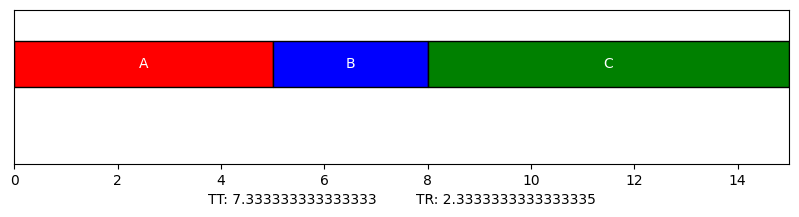

In [15]:
scheduling = sjf(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)

##STCF

[('A', 5), ('B', 8), ('C', 15)]


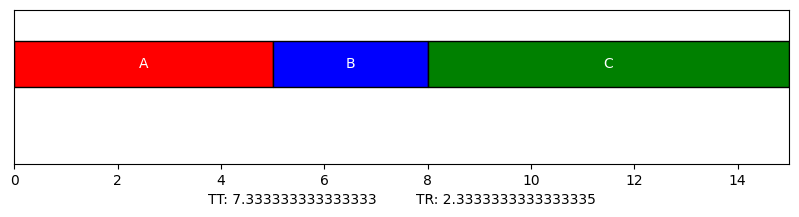

In [16]:
scheduling = stcf(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)

##RR

[('A', 1), ('A', 2), ('B', 3), ('A', 4), ('C', 5), ('B', 6), ('A', 7), ('C', 8), ('B', 9), ('A', 10), ('C', 11), ('C', 12), ('C', 13), ('C', 14), ('C', 15)]


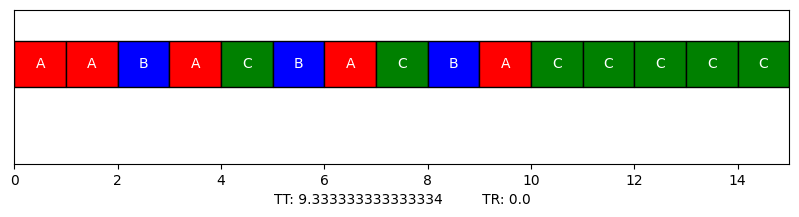

In [18]:
scheduling = rr(processes,1)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)

##Modelo

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[('A', 2), ('B', 5), ('C', 6), ('A', 9), ('C', 15)]


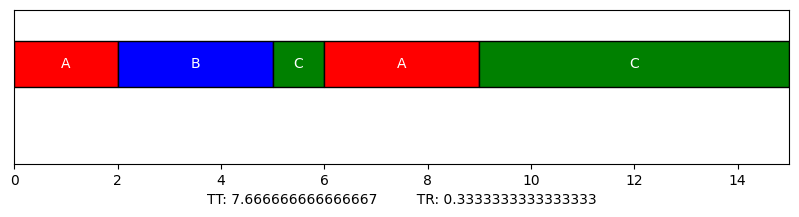

In [24]:
scheduling = modelo(processes)
print(scheduling)
tt = t_turnaround(scheduling, processes)
tr = t_response(scheduling, processes)
plot_scheduling(scheduling,tt,tr)